In [61]:
import tensorflow as tf
from tqdm import tqdm
import copy
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [62]:
clients = [0 , 1, 2, 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19]
epochs = 20

In [63]:
import tensorflow as tf
import numpy as np

# Load the MNIST dataset
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
x_train_all = x_train_all.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [64]:
from sklearn.model_selection import train_test_split

# assume X is your feature data and y is your target data
X_train, X_test, y_train, y_test = train_test_split(
    x_train_all, y_train_all, test_size=0.2, random_state=42
)

# split data into n parts
n_parts = len(clients)
part_size = len(X_train) // n_parts
dataset_parts = []
for i in range(n_parts):
    start = i * part_size
    end = (i + 1) * part_size
    X_part = X_train[start:end]
    y_part = y_train[start:end]
    dataset_parts.append((X_part, y_part))

In [65]:
def model_init():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(8, activation="relu"),
            tf.keras.layers.Dense(10, activation="softmax"),
        ]
    )
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [66]:
models = []
for _ in range(len(clients)):
    models.append(model_init())

In [67]:
import numpy as np
from Pyfhel import Pyfhel

HE = Pyfhel()  # Creating empty Pyfhel object
ckks_params = {
    "scheme": "CKKS",  # can also be 'ckks'
    "n": 2**14,  # Polynomial modulus degree. For CKKS, n/2 values can be
    #  encoded in a single ciphertext.
    #  Typ. 2^D for D in [10, 15]
    "scale": 2**30,  # All the encodings will use it for float->fixed point
    #  conversion: x_fix = round(x_float * scale)
    #  You can use this as default scale or use a different
    #  scale on each operation (set in HE.encryptFrac)
    "qi_sizes": [60, 30, 30, 30, 60],  # Number of bits of each prime in the chain.
    # Intermediate values should be  close to log2(scale)
    # for each operation, to have small rounding errors.
}
HE.contextGen(**ckks_params)  # Generate context for ckks scheme
HE.keyGen()  # Key Generation: generates a pair of public/secret keys
HE.rotateKeyGen()

In [68]:
shapedims = [l.shape for l in models[0].get_weights()]
print(shapedims)

[(784, 8), (8,), (8, 10), (10,)]


In [69]:
def encrypt_wt(wtarray):
    cwt = []
    for layer in wtarray:
        flat_array = layer.astype(np.float64).flatten()

        chunks = np.array_split(flat_array, (len(flat_array) + 2**10 - 1) // 2**10)
        clayer = []
        for chunk in chunks:
            ptxt = HE.encodeFrac(chunk)
            ctxt = HE.encryptPtxt(ptxt)
            clayer.append(ctxt)
        cwt.append(clayer.copy())
    return cwt
        

In [70]:
def aggregate_wt(cwts):
    resmodel = []
    for j in range(len(cwts[0])):  # for layers
        layer = []
        for k in range(len(cwts[0][j])):  # for chunks
            tmp = cwts[0][j][k].copy()
            for i in range(1, len(cwts)):  # for clients
                tmp = tmp + cwts[i][j][k]
            tmp = tmp / len(cwts)
            layer.append(tmp)
        resmodel.append(layer)

    res = [resmodel.copy() for _ in range(len(clients))]
    return res
    

In [71]:
def decrypt_weights(res):
    decrypted_weights = []
    for client_weights, model in zip(res, models):
        decrypted_client_weights = []
        wtarray = model.get_weights()
        for layer_weights, layer in zip(client_weights, wtarray):
            decrypted_layer_weights = []
            flat_array = layer.astype(np.float64).flatten()
            chunks = np.array_split(flat_array, (len(flat_array) + 2**10 - 1) // 2**10)
            for chunk, encrypted_chunk in zip(chunks, layer_weights):
                decrypted_chunk = HE.decryptFrac(encrypted_chunk)
                original_chunk_size = len(chunk)
                decrypted_chunk = decrypted_chunk[:original_chunk_size]
                decrypted_layer_weights.append(decrypted_chunk)
            decrypted_layer_weights = np.concatenate(decrypted_layer_weights, axis=0)
            decrypted_layer_weights = decrypted_layer_weights.reshape(layer.shape)
            decrypted_client_weights.append(decrypted_layer_weights)
        decrypted_weights.append(decrypted_client_weights)
    return decrypted_weights

In [72]:
accuracies = [[] for _ in range(len(clients))]
losses = [[] for _ in range(len(clients))]

In [73]:
cwts = [encrypt_wt(model.get_weights()) for model in models]
for e in tqdm(range(epochs)):
    wts = decrypt_weights(cwts)
    cwts = []
    for wt,model , dataset , i , in zip(wts, models, dataset_parts , clients):
        model.set_weights(wt)
        history = model.fit(dataset[0], dataset[1], epochs=1,  verbose=1)
        print(history.history["accuracy"][0], history.history["loss"][0])
        accuracies[i ].append(history.history["accuracy"][0])
        losses[i].append(history.history["loss"][0])
        wtarray = model.get_weights()
        cwts.append(encrypt_wt(wtarray))

    cwts = aggregate_wt(cwts)

  0%|          | 0/20 [00:00<?, ?it/s]

75/75 [==============================] - 0s 2ms/step - loss: 1.9439 - accuracy: 0.3342
0.33416667580604553 1.9439363479614258
75/75 [==============================] - 0s 815us/step - loss: 2.0749 - accuracy: 0.1762
0.17624999582767487 2.0748555660247803
75/75 [==============================] - 0s 789us/step - loss: 1.9980 - accuracy: 0.2750
0.2750000059604645 1.9979772567749023
75/75 [==============================] - 0s 830us/step - loss: 1.9943 - accuracy: 0.3125
0.3125 1.9942842721939087
75/75 [==============================] - 0s 802us/step - loss: 2.0132 - accuracy: 0.2754
0.27541667222976685 2.013155221939087
75/75 [==============================] - 0s 767us/step - loss: 2.0465 - accuracy: 0.2479
0.24791666865348816 2.0465054512023926
75/75 [==============================] - 1s 844us/step - loss: 2.2185 - accuracy: 0.1937
0.19374999403953552 2.218467950820923
75/75 [==============================] - 0s 1ms/step - loss: 2.0325 - accuracy: 0.2496
0.24958333373069763 2.0324573516845

  5%|▌         | 1/20 [00:10<03:23, 10.71s/it]

75/75 [==============================] - 0s 755us/step - loss: 2.1332 - accuracy: 0.3433
0.34333333373069763 2.133207082748413
75/75 [==============================] - 0s 733us/step - loss: 2.1238 - accuracy: 0.3233
0.3233333230018616 2.1238181591033936
75/75 [==============================] - 0s 735us/step - loss: 2.1186 - accuracy: 0.2854
0.2854166626930237 2.1185600757598877
75/75 [==============================] - 0s 792us/step - loss: 2.0789 - accuracy: 0.3525
0.35249999165534973 2.078909158706665
75/75 [==============================] - 0s 760us/step - loss: 2.1402 - accuracy: 0.3229
0.3229166567325592 2.140178680419922
75/75 [==============================] - 0s 840us/step - loss: 2.0949 - accuracy: 0.3229
0.3229166567325592 2.094876289367676
75/75 [==============================] - 0s 768us/step - loss: 2.0121 - accuracy: 0.3504
0.3504166603088379 2.0120861530303955
75/75 [==============================] - 0s 1ms/step - loss: 2.1087 - accuracy: 0.3129
0.31291666626930237 2.1086

 10%|█         | 2/20 [00:15<02:09,  7.21s/it]

75/75 [==============================] - 0s 882us/step - loss: 1.6295 - accuracy: 0.5579
0.5579166412353516 1.6295297145843506
75/75 [==============================] - 0s 770us/step - loss: 1.6063 - accuracy: 0.5442
0.5441666841506958 1.6062573194503784
75/75 [==============================] - 0s 1ms/step - loss: 1.6185 - accuracy: 0.5450
0.5450000166893005 1.6184744834899902
75/75 [==============================] - 0s 768us/step - loss: 1.5994 - accuracy: 0.5500
0.550000011920929 1.5993574857711792
75/75 [==============================] - 0s 1ms/step - loss: 1.6215 - accuracy: 0.5508
0.5508333444595337 1.6215100288391113
75/75 [==============================] - 0s 771us/step - loss: 1.6072 - accuracy: 0.5479
0.5479166507720947 1.607157826423645
75/75 [==============================] - 0s 1ms/step - loss: 1.5786 - accuracy: 0.5542
0.5541666746139526 1.5785902738571167
75/75 [==============================] - 0s 745us/step - loss: 1.6140 - accuracy: 0.5450
0.5450000166893005 1.614034175

 15%|█▌        | 3/20 [00:20<01:43,  6.07s/it]

75/75 [==============================] - 0s 808us/step - loss: 1.1327 - accuracy: 0.7379
0.7379166483879089 1.1327003240585327
75/75 [==============================] - 0s 827us/step - loss: 1.1094 - accuracy: 0.7433
0.7433333396911621 1.109436273574829
75/75 [==============================] - 0s 807us/step - loss: 1.1143 - accuracy: 0.7467
0.746666669845581 1.1142927408218384
75/75 [==============================] - 0s 815us/step - loss: 1.1137 - accuracy: 0.7450
0.7450000047683716 1.1137064695358276
75/75 [==============================] - 0s 832us/step - loss: 1.1337 - accuracy: 0.7446
0.7445833086967468 1.1337392330169678
75/75 [==============================] - 0s 996us/step - loss: 1.1237 - accuracy: 0.7400
0.7400000095367432 1.1237289905548096
75/75 [==============================] - 0s 775us/step - loss: 1.1236 - accuracy: 0.7521
0.7520833611488342 1.1235947608947754
75/75 [==============================] - 0s 753us/step - loss: 1.1180 - accuracy: 0.7592
0.7591666579246521 1.118

 20%|██        | 4/20 [00:25<01:29,  5.61s/it]

75/75 [==============================] - 0s 775us/step - loss: 0.8543 - accuracy: 0.7837
0.7837499976158142 0.8543034791946411
75/75 [==============================] - 0s 781us/step - loss: 0.8244 - accuracy: 0.8075
0.8075000047683716 0.8244467377662659
75/75 [==============================] - 0s 740us/step - loss: 0.8294 - accuracy: 0.8025
0.8025000095367432 0.8293506503105164
75/75 [==============================] - 0s 852us/step - loss: 0.8316 - accuracy: 0.8062
0.8062499761581421 0.8315982818603516
75/75 [==============================] - 0s 795us/step - loss: 0.8511 - accuracy: 0.7904
0.7904166579246521 0.8510549664497375
75/75 [==============================] - 0s 759us/step - loss: 0.8516 - accuracy: 0.7937
0.793749988079071 0.8515602946281433
75/75 [==============================] - 0s 760us/step - loss: 0.8552 - accuracy: 0.7937
0.793749988079071 0.8551540970802307
75/75 [==============================] - 0s 800us/step - loss: 0.8389 - accuracy: 0.8046
0.8045833110809326 0.838

 25%|██▌       | 5/20 [00:29<01:19,  5.29s/it]

0.809583306312561 0.8083193898200989
75/75 [==============================] - 0s 744us/step - loss: 0.7048 - accuracy: 0.8142
0.8141666650772095 0.7047882676124573
75/75 [==============================] - 0s 1ms/step - loss: 0.6764 - accuracy: 0.8313
0.831250011920929 0.6763604283332825
75/75 [==============================] - 0s 764us/step - loss: 0.6737 - accuracy: 0.8346
0.8345833420753479 0.6737110018730164
75/75 [==============================] - 0s 816us/step - loss: 0.6820 - accuracy: 0.8300
0.8299999833106995 0.6819847226142883
75/75 [==============================] - 0s 768us/step - loss: 0.7013 - accuracy: 0.8117
0.8116666674613953 0.7012641429901123
75/75 [==============================] - 0s 952us/step - loss: 0.7051 - accuracy: 0.8229
0.8229166865348816 0.7050755620002747
75/75 [==============================] - 0s 772us/step - loss: 0.7118 - accuracy: 0.8204
0.8204166889190674 0.7117866277694702
75/75 [==============================] - 0s 937us/step - loss: 0.6843 - accur

 30%|███       | 6/20 [00:34<01:11,  5.14s/it]

75/75 [==============================] - 0s 908us/step - loss: 0.6149 - accuracy: 0.8329
0.8329166769981384 0.6149066686630249
75/75 [==============================] - 0s 811us/step - loss: 0.5858 - accuracy: 0.8512
0.8512499928474426 0.585798978805542
75/75 [==============================] - 0s 1ms/step - loss: 0.5828 - accuracy: 0.8496
0.8495833277702332 0.5827773213386536
75/75 [==============================] - 0s 774us/step - loss: 0.5942 - accuracy: 0.8450
0.8450000286102295 0.5941988229751587
75/75 [==============================] - 0s 1ms/step - loss: 0.6062 - accuracy: 0.8392
0.8391666412353516 0.6061832904815674
75/75 [==============================] - 0s 792us/step - loss: 0.6162 - accuracy: 0.8383
0.8383333086967468 0.61616051197052
75/75 [==============================] - 0s 1ms/step - loss: 0.6232 - accuracy: 0.8404
0.840416669845581 0.6231721639633179
75/75 [==============================] - 0s 851us/step - loss: 0.5934 - accuracy: 0.8483
0.8483333587646484 0.59342831373

 35%|███▌      | 7/20 [00:39<01:05,  5.05s/it]

0.856249988079071 0.5612552165985107
75/75 [==============================] - 0s 767us/step - loss: 0.5579 - accuracy: 0.8487
0.8487499952316284 0.5578593015670776
75/75 [==============================] - 0s 1ms/step - loss: 0.5289 - accuracy: 0.8608
0.8608333468437195 0.5289166569709778
75/75 [==============================] - 0s 730us/step - loss: 0.5222 - accuracy: 0.8687
0.8687499761581421 0.5221849083900452
75/75 [==============================] - 0s 767us/step - loss: 0.5374 - accuracy: 0.8512
0.8512499928474426 0.5374099612236023
75/75 [==============================] - 0s 766us/step - loss: 0.5449 - accuracy: 0.8521
0.8520833253860474 0.5448870062828064
75/75 [==============================] - 0s 1ms/step - loss: 0.5583 - accuracy: 0.8454
0.8454166650772095 0.5582735538482666
75/75 [==============================] - 0s 804us/step - loss: 0.5707 - accuracy: 0.8525
0.8525000214576721 0.5706638693809509
75/75 [==============================] - 0s 743us/step - loss: 0.5336 - accura

 40%|████      | 8/20 [00:44<00:59,  4.99s/it]

0.8658333420753479 0.5049728155136108
75/75 [==============================] - 0s 715us/step - loss: 0.5184 - accuracy: 0.8558
0.8558333516120911 0.5183518528938293
75/75 [==============================] - 0s 761us/step - loss: 0.4873 - accuracy: 0.8729
0.8729166388511658 0.4872889816761017
75/75 [==============================] - 0s 895us/step - loss: 0.4827 - accuracy: 0.8733
0.8733333349227905 0.48271697759628296
75/75 [==============================] - 0s 703us/step - loss: 0.4984 - accuracy: 0.8600
0.8600000143051147 0.49835205078125
75/75 [==============================] - 0s 1ms/step - loss: 0.5026 - accuracy: 0.8604
0.8604166507720947 0.5025571584701538
75/75 [==============================] - 0s 723us/step - loss: 0.5189 - accuracy: 0.8571
0.8570833206176758 0.5189397931098938
75/75 [==============================] - 0s 725us/step - loss: 0.5314 - accuracy: 0.8612
0.8612499833106995 0.531407356262207
75/75 [==============================] - 0s 796us/step - loss: 0.4936 - accur

 45%|████▌     | 9/20 [00:49<00:53,  4.88s/it]

75/75 [==============================] - 0s 757us/step - loss: 0.4891 - accuracy: 0.8621
0.8620833158493042 0.48914623260498047
75/75 [==============================] - 0s 752us/step - loss: 0.4588 - accuracy: 0.8796
0.8795833587646484 0.45884501934051514
75/75 [==============================] - 0s 705us/step - loss: 0.4503 - accuracy: 0.8888
0.8887500166893005 0.45030897855758667
75/75 [==============================] - 0s 1ms/step - loss: 0.4696 - accuracy: 0.8658
0.8658333420753479 0.4696374535560608
75/75 [==============================] - 0s 722us/step - loss: 0.4732 - accuracy: 0.8696
0.8695833086967468 0.4731842577457428
75/75 [==============================] - 0s 750us/step - loss: 0.4872 - accuracy: 0.8629
0.8629166483879089 0.48716771602630615
75/75 [==============================] - 0s 761us/step - loss: 0.5014 - accuracy: 0.8654
0.8654166460037231 0.5013546347618103
75/75 [==============================] - 0s 784us/step - loss: 0.4655 - accuracy: 0.8712
0.8712499737739563 0

 50%|█████     | 10/20 [00:53<00:48,  4.83s/it]

0.8829166889190674 0.43202656507492065
75/75 [==============================] - 0s 846us/step - loss: 0.4651 - accuracy: 0.8696
0.8695833086967468 0.4650532007217407
75/75 [==============================] - 0s 770us/step - loss: 0.4347 - accuracy: 0.8817
0.8816666603088379 0.43467652797698975
75/75 [==============================] - 0s 812us/step - loss: 0.4233 - accuracy: 0.8933
0.8933333158493042 0.4233287274837494
75/75 [==============================] - 0s 784us/step - loss: 0.4454 - accuracy: 0.8721
0.872083306312561 0.4454423487186432
75/75 [==============================] - 0s 761us/step - loss: 0.4480 - accuracy: 0.8733
0.8733333349227905 0.44803279638290405
75/75 [==============================] - 0s 1ms/step - loss: 0.4628 - accuracy: 0.8729
0.8729166388511658 0.46278107166290283
75/75 [==============================] - 0s 799us/step - loss: 0.4796 - accuracy: 0.8708
0.8708333373069763 0.47955846786499023
75/75 [==============================] - 0s 849us/step - loss: 0.4412 -

 55%|█████▌    | 11/20 [00:58<00:43,  4.83s/it]

75/75 [==============================] - 0s 738us/step - loss: 0.4482 - accuracy: 0.8746
0.8745833039283752 0.44818663597106934
75/75 [==============================] - 0s 712us/step - loss: 0.4180 - accuracy: 0.8875
0.887499988079071 0.4180399179458618
75/75 [==============================] - 0s 724us/step - loss: 0.4059 - accuracy: 0.9004
0.9004166722297668 0.40591752529144287
75/75 [==============================] - 0s 717us/step - loss: 0.4275 - accuracy: 0.8783
0.878333330154419 0.427491694688797
75/75 [==============================] - 0s 778us/step - loss: 0.4261 - accuracy: 0.8763
0.8762500286102295 0.42612555623054504
75/75 [==============================] - 0s 730us/step - loss: 0.4445 - accuracy: 0.8746
0.8745833039283752 0.4445120096206665
75/75 [==============================] - 0s 688us/step - loss: 0.4623 - accuracy: 0.8813
0.8812500238418579 0.4622924327850342
75/75 [==============================] - 0s 685us/step - loss: 0.4233 - accuracy: 0.8833
0.8833333253860474 0.4

 60%|██████    | 12/20 [01:03<00:38,  4.77s/it]

75/75 [==============================] - 0s 791us/step - loss: 0.4323 - accuracy: 0.8733
0.8733333349227905 0.4323376417160034
75/75 [==============================] - 0s 765us/step - loss: 0.4034 - accuracy: 0.8854
0.8854166865348816 0.40342947840690613
75/75 [==============================] - 0s 788us/step - loss: 0.3907 - accuracy: 0.9029
0.902916669845581 0.3907208740711212
75/75 [==============================] - 0s 720us/step - loss: 0.4158 - accuracy: 0.8804
0.8804166913032532 0.415810763835907
75/75 [==============================] - 0s 733us/step - loss: 0.4117 - accuracy: 0.8788
0.8787500262260437 0.4116642475128174
75/75 [==============================] - 0s 717us/step - loss: 0.4310 - accuracy: 0.8808
0.8808333277702332 0.43096598982810974
75/75 [==============================] - 0s 724us/step - loss: 0.4496 - accuracy: 0.8825
0.8824999928474426 0.4496321976184845
75/75 [==============================] - 0s 718us/step - loss: 0.4092 - accuracy: 0.8871
0.8870833516120911 0.4

 65%|██████▌   | 13/20 [01:07<00:32,  4.71s/it]

75/75 [==============================] - 0s 1ms/step - loss: 0.4210 - accuracy: 0.8788
0.8787500262260437 0.42097362875938416
75/75 [==============================] - 0s 683us/step - loss: 0.3915 - accuracy: 0.8896
0.8895833492279053 0.3915066421031952
75/75 [==============================] - 0s 963us/step - loss: 0.3765 - accuracy: 0.9075
0.9075000286102295 0.37646493315696716
75/75 [==============================] - 0s 830us/step - loss: 0.4015 - accuracy: 0.8854
0.8854166865348816 0.40146997570991516
75/75 [==============================] - 0s 705us/step - loss: 0.3971 - accuracy: 0.8854
0.8854166865348816 0.3970707654953003
75/75 [==============================] - 0s 799us/step - loss: 0.4140 - accuracy: 0.8883
0.8883333206176758 0.4140078127384186
75/75 [==============================] - 0s 719us/step - loss: 0.4356 - accuracy: 0.8846
0.8845833539962769 0.4355625510215759
75/75 [==============================] - 0s 778us/step - loss: 0.3989 - accuracy: 0.8875
0.887499988079071 0.3

 70%|███████   | 14/20 [01:12<00:28,  4.69s/it]

75/75 [==============================] - 0s 808us/step - loss: 0.4105 - accuracy: 0.8804
0.8804166913032532 0.4105108976364136
75/75 [==============================] - 0s 726us/step - loss: 0.3796 - accuracy: 0.8908
0.89083331823349 0.379630982875824
75/75 [==============================] - 0s 753us/step - loss: 0.3653 - accuracy: 0.9079
0.9079166650772095 0.36534184217453003
75/75 [==============================] - 0s 748us/step - loss: 0.3901 - accuracy: 0.8854
0.8854166865348816 0.3901090621948242
75/75 [==============================] - 0s 895us/step - loss: 0.3889 - accuracy: 0.8858
0.8858333230018616 0.3889135718345642
75/75 [==============================] - 0s 785us/step - loss: 0.4059 - accuracy: 0.8896
0.8895833492279053 0.4059392809867859
75/75 [==============================] - 0s 774us/step - loss: 0.4265 - accuracy: 0.8858
0.8858333230018616 0.42645350098609924
75/75 [==============================] - 0s 747us/step - loss: 0.3866 - accuracy: 0.8896
0.8895833492279053 0.38

 75%|███████▌  | 15/20 [01:17<00:23,  4.73s/it]

75/75 [==============================] - 0s 849us/step - loss: 0.4009 - accuracy: 0.8858
0.8858333230018616 0.40091583132743835
75/75 [==============================] - 0s 764us/step - loss: 0.3718 - accuracy: 0.8958
0.8958333134651184 0.3718017339706421
75/75 [==============================] - 0s 826us/step - loss: 0.3563 - accuracy: 0.9104
0.9104166626930237 0.35629037022590637
75/75 [==============================] - 0s 758us/step - loss: 0.3815 - accuracy: 0.8896
0.8895833492279053 0.38149774074554443
75/75 [==============================] - 0s 833us/step - loss: 0.3770 - accuracy: 0.8904
0.89041668176651 0.3770173192024231
75/75 [==============================] - 0s 773us/step - loss: 0.3959 - accuracy: 0.8900
0.8899999856948853 0.39590689539909363
75/75 [==============================] - 0s 804us/step - loss: 0.4196 - accuracy: 0.8875
0.887499988079071 0.41964277625083923
75/75 [==============================] - 0s 823us/step - loss: 0.3791 - accuracy: 0.8892
0.8891666531562805 0

 80%|████████  | 16/20 [01:22<00:19,  4.76s/it]

75/75 [==============================] - 0s 1ms/step - loss: 0.3926 - accuracy: 0.8917
0.8916666507720947 0.39262276887893677
75/75 [==============================] - 0s 793us/step - loss: 0.3632 - accuracy: 0.8967
0.8966666460037231 0.3632446229457855
75/75 [==============================] - 0s 1ms/step - loss: 0.3490 - accuracy: 0.9104
0.9104166626930237 0.3489609360694885
75/75 [==============================] - 0s 795us/step - loss: 0.3745 - accuracy: 0.8896
0.8895833492279053 0.37447232007980347
75/75 [==============================] - 0s 1ms/step - loss: 0.3693 - accuracy: 0.8883
0.8883333206176758 0.3692859411239624
75/75 [==============================] - 0s 937us/step - loss: 0.3887 - accuracy: 0.8933
0.8933333158493042 0.388748437166214
75/75 [==============================] - 0s 1ms/step - loss: 0.4128 - accuracy: 0.8863
0.8862500190734863 0.41280972957611084
75/75 [==============================] - 0s 817us/step - loss: 0.3723 - accuracy: 0.8929
0.8929166793823242 0.3722900

 85%|████████▌ | 17/20 [01:26<00:14,  4.79s/it]

75/75 [==============================] - 0s 922us/step - loss: 0.3853 - accuracy: 0.8913
0.8912500143051147 0.38532087206840515
75/75 [==============================] - 0s 802us/step - loss: 0.3582 - accuracy: 0.8963
0.8962500095367432 0.35824474692344666
75/75 [==============================] - 0s 1ms/step - loss: 0.3422 - accuracy: 0.9150
0.9150000214576721 0.3421781659126282
75/75 [==============================] - 0s 839us/step - loss: 0.3668 - accuracy: 0.8883
0.8883333206176758 0.3668382465839386
75/75 [==============================] - 0s 1ms/step - loss: 0.3644 - accuracy: 0.8900
0.8899999856948853 0.36443960666656494
75/75 [==============================] - 0s 812us/step - loss: 0.3819 - accuracy: 0.8967
0.8966666460037231 0.38193246722221375
75/75 [==============================] - 0s 812us/step - loss: 0.4064 - accuracy: 0.8888
0.8887500166893005 0.4064176082611084
75/75 [==============================] - 0s 833us/step - loss: 0.3632 - accuracy: 0.8925
0.8924999833106995 0.3

 90%|█████████ | 18/20 [01:31<00:09,  4.83s/it]

75/75 [==============================] - 0s 827us/step - loss: 0.3797 - accuracy: 0.8921
0.8920833468437195 0.37967219948768616
75/75 [==============================] - 0s 818us/step - loss: 0.3521 - accuracy: 0.9017
0.9016666412353516 0.3521260619163513
75/75 [==============================] - 0s 835us/step - loss: 0.3365 - accuracy: 0.9087
0.9087499976158142 0.3364730477333069
75/75 [==============================] - 0s 818us/step - loss: 0.3602 - accuracy: 0.8929
0.8929166793823242 0.3601577579975128
75/75 [==============================] - 0s 814us/step - loss: 0.3586 - accuracy: 0.8929
0.8929166793823242 0.3586196005344391
75/75 [==============================] - 0s 797us/step - loss: 0.3759 - accuracy: 0.8954
0.8954166769981384 0.3758653402328491
75/75 [==============================] - 0s 786us/step - loss: 0.4003 - accuracy: 0.8954
0.8954166769981384 0.40033984184265137
75/75 [==============================] - 0s 774us/step - loss: 0.3603 - accuracy: 0.8950
0.8949999809265137 0

 95%|█████████▌| 19/20 [01:36<00:04,  4.84s/it]

75/75 [==============================] - 0s 790us/step - loss: 0.3729 - accuracy: 0.8950
0.8949999809265137 0.3728856146335602
75/75 [==============================] - 0s 850us/step - loss: 0.3478 - accuracy: 0.8996
0.8995833396911621 0.3477824330329895
75/75 [==============================] - 0s 870us/step - loss: 0.3310 - accuracy: 0.9129
0.9129166603088379 0.33096250891685486
75/75 [==============================] - 0s 817us/step - loss: 0.3558 - accuracy: 0.8913
0.8912500143051147 0.3558198809623718
75/75 [==============================] - 0s 796us/step - loss: 0.3524 - accuracy: 0.8925
0.8924999833106995 0.3524045944213867
75/75 [==============================] - 0s 794us/step - loss: 0.3700 - accuracy: 0.8967
0.8966666460037231 0.369962215423584
75/75 [==============================] - 0s 853us/step - loss: 0.3965 - accuracy: 0.8938
0.893750011920929 0.3964816927909851
75/75 [==============================] - 0s 837us/step - loss: 0.3532 - accuracy: 0.8963
0.8962500095367432 0.35

100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


In [74]:
accuracies


[[0.33416667580604553,
  0.34333333373069763,
  0.5579166412353516,
  0.7379166483879089,
  0.7837499976158142,
  0.8141666650772095,
  0.8329166769981384,
  0.8487499952316284,
  0.8558333516120911,
  0.8620833158493042,
  0.8695833086967468,
  0.8745833039283752,
  0.8733333349227905,
  0.8787500262260437,
  0.8804166913032532,
  0.8858333230018616,
  0.8916666507720947,
  0.8912500143051147,
  0.8920833468437195,
  0.8949999809265137],
 [0.17624999582767487,
  0.3233333230018616,
  0.5441666841506958,
  0.7433333396911621,
  0.8075000047683716,
  0.831250011920929,
  0.8512499928474426,
  0.8608333468437195,
  0.8729166388511658,
  0.8795833587646484,
  0.8816666603088379,
  0.887499988079071,
  0.8854166865348816,
  0.8895833492279053,
  0.89083331823349,
  0.8958333134651184,
  0.8966666460037231,
  0.8962500095367432,
  0.9016666412353516,
  0.8995833396911621],
 [0.2750000059604645,
  0.2854166626930237,
  0.5450000166893005,
  0.746666669845581,
  0.8025000095367432,
  0.834583

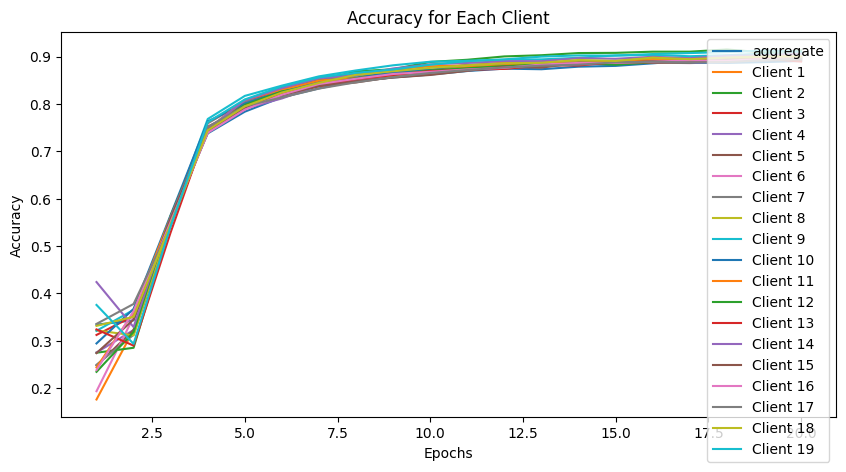

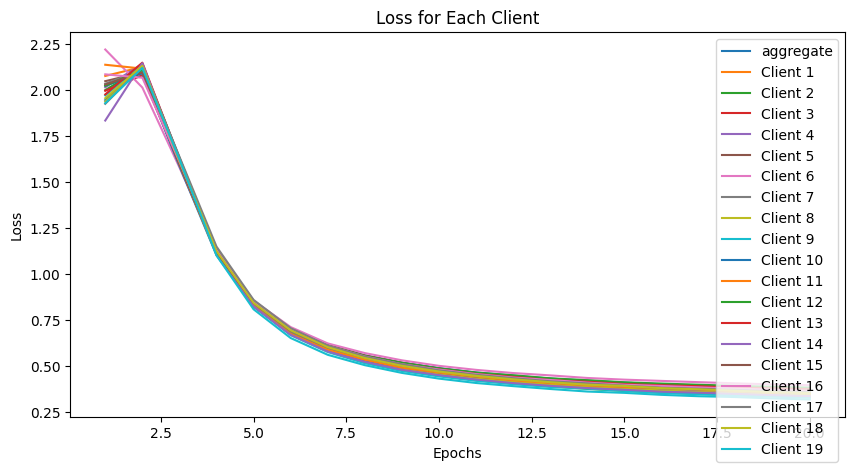

In [78]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 5))
for i, client in enumerate(clients):
    plt.plot(
        epochs_range,
        accuracies[i],
        label=f"Client {client}" if client != 0 else "aggregate",
    )
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy for Each Client")
plt.show()

plt.figure(figsize=(10, 5))
for i, client in enumerate(clients):
    plt.plot(epochs_range, losses[i], label=f"Client {client}" if client != 0 else "aggregate")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss for Each Client")
plt.show()

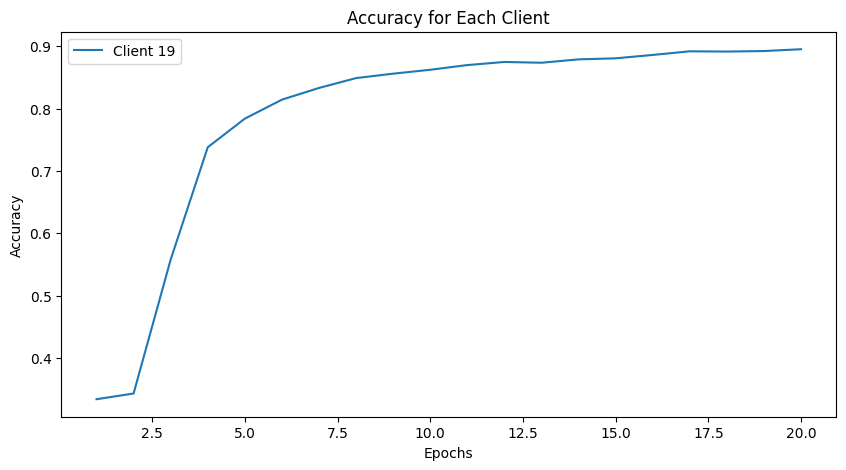

In [76]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 5))
# for i, client in enumerate(clients):
plt.plot(epochs_range, accuracies[0], label=f"Client {client}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy for Each Client")
plt.show()

1/1 [==============================] - 0s 39ms/step


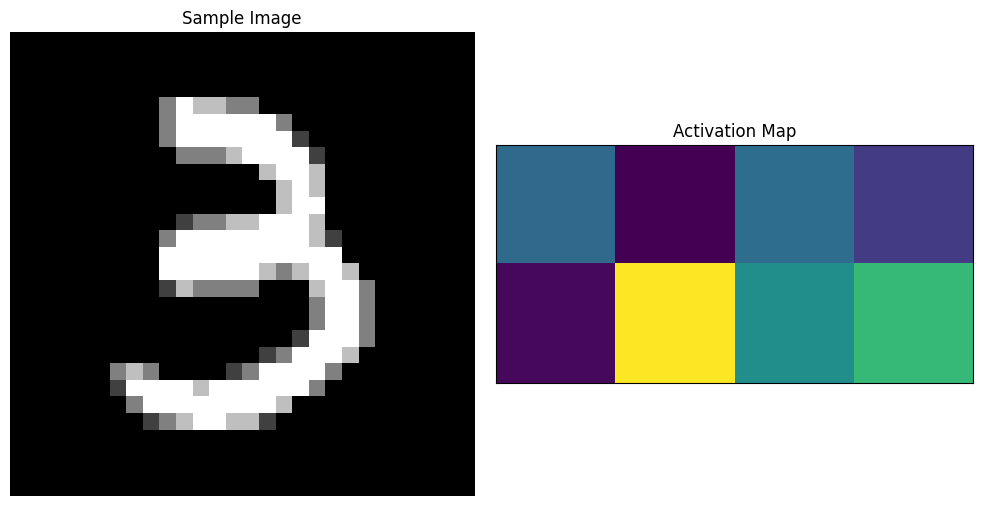

In [82]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

model = models[0]
# Assuming you have a trained model named 'model'
# and input data 'X_test' and corresponding labels 'y_test'

# Select a sample image from the test set
# Select a sample image from the test set
sample_image = X_test[1]  # Adjust the index as needed
sample_label = y_test[1]

# Preprocess the sample image
sample_image = sample_image[np.newaxis, ...]  # Add batch dimension

# Initialize the model
# model = model_init()

# Create a model that outputs the activations of the first dense layer
layer_name = "dense_42"  # Name of the first dense layer in your model
activation_model = Model(
    inputs=model.inputs, outputs=model.get_layer(layer_name).output
)

# Get the activations of the first dense layer
activations = activation_model.predict(sample_image)

# Plot the sample image and the activation map
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(sample_image[0], cmap="gray")  # Assuming grayscale image
ax1.set_title("Sample Image")
ax1.axis("off")

ax2.imshow(activations[0].reshape(2, 4), cmap="viridis", interpolation="nearest")
ax2.set_title("Activation Map")
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()